In [1]:
# 6 models split between regression and classification 
# thimo: RF, KNN, decision tree C
# Llan: SVC, SVR, Lasso  


In [2]:
import pandas as pd
import numpy as np 
import sklearn.svm as svm 
import sklearn.model_selection as skm
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix, mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


In [3]:
f = "ml2023_projectmbf-main/data_labeled_fixed.csv"
exp = pd.read_csv(f, header = 0)

In [4]:
# splitting the data 
train, test = skm.train_test_split(exp, random_state=1)
X_train, X_test = train.drop(["CLASS", "CELLTYPE"], axis=1), test.drop(["CLASS", "CELLTYPE"], axis = 1)
Y_train, Y_test = train["CLASS"], test["CLASS"]



In [122]:
# defining and fitting the model
#clf = svm.SVC(decision_function_shape='ovr', kernel = "linear", C=1 )
clf = svm.LinearSVC(dual="auto")
clfit = clf.fit(X_train, Y_train)

In [123]:
pd.DataFrame(clfit.coef_)

,0,1,2,3,4,5,6,7,8,9,...,442,443,444,445,446,447,448,449,450,451
0,0.001867,0.040261,-0.022637,0.028025,-0.012749,0.031479,0.014925,0.014573,-0.019487,-0.026422,...,-0.008382,0.000317,-0.009257,-0.025101,-0.003184,0.019335,-0.020798,-0.009278,0.006314,0.000741
1,0.004117,-0.043437,0.022511,-0.040535,0.052425,0.006406,-0.012623,-0.015351,0.015654,-0.003218,...,0.005040,0.049647,0.044852,0.016964,0.001966,-0.021461,0.035231,0.064467,-0.035524,0.003801
2,0.008130,-0.022614,-0.012460,0.019808,0.002239,0.004412,-0.038799,-0.004411,-0.002190,0.044482,...,-0.017231,-0.038314,-0.025644,-0.043909,-0.034038,0.006347,-0.025181,-0.084996,0.007992,0.007672
3,-0.025338,-0.019362,0.001424,-0.007821,-0.007284,0.013712,-0.043269,-0.003036,-0.017157,-0.028498,...,-0.021338,0.004675,0.001186,0.022050,0.001826,0.017257,0.027671,0.008987,0.012143,-0.004051


In [124]:
clfit.coef_

array([[ 0.00186735,  0.04026099, -0.022637  , ..., -0.00927798,
         0.00631421,  0.00074141],
       [ 0.00411739, -0.04343683,  0.0225113 , ...,  0.06446686,
        -0.0355243 ,  0.00380071],
       [ 0.00813018, -0.02261432, -0.01245972, ..., -0.08499624,
         0.0079918 ,  0.00767239],
       [-0.02533849, -0.01936235,  0.00142445, ...,  0.00898734,
         0.01214315, -0.00405064]])

In [125]:
clfit.decision_function_shape = "ovr"

In [126]:
dec = clfit.decision_function(X_train)

In [105]:
# predicting on the test set
Y_pred = clfit.predict(X_test)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Amacrine'),
  Text(1, 0, 'Cone Bipolar OFF'),
  Text(2, 0, 'Cone Bipolar ON'),
  Text(3, 0, 'Rod Bipolar')])

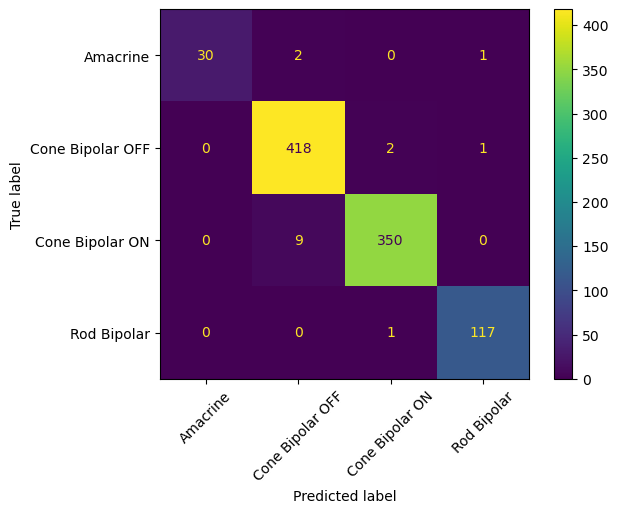

In [130]:
# building the confusion matrix 
conf_matrix = confusion_matrix(Y_test, Y_pred)
conf_matrix = ConfusionMatrixDisplay(conf_matrix, display_labels=clfit.classes_)

conf_matrix.plot()
plt.xticks(rotation=45)


In [8]:
# optimizing parameters
to_optimize = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['poly']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['sigmoid']}  
 ]

search = skm.GridSearchCV(clf, param_grid=to_optimize,)
find = search.fit(X_train, Y_train)

In [9]:
# turning the optimization results into a dataframe
pd.DataFrame(find.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.188943,0.005039,0.047831,0.000938,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.987478,0.978533,0.978533,0.996416,0.985663,0.985325,0.006633,1
1,0.185966,0.003353,0.047662,0.000818,10,linear,NaN,"{'C': 10, 'kernel': 'linear'}",0.987478,0.978533,0.978533,0.996416,0.985663,0.985325,0.006633,1
2,0.187206,0.003697,0.047748,0.001322,100,linear,NaN,"{'C': 100, 'kernel': 'linear'}",0.987478,0.978533,0.978533,0.996416,0.985663,0.985325,0.006633,1
3,0.186037,0.003496,0.047460,0.000929,1000,linear,NaN,"{'C': 1000, 'kernel': 'linear'}",0.987478,0.978533,0.978533,0.996416,0.985663,0.985325,0.006633,1
4,0.557921,0.004780,0.189541,0.002468,1,rbf,0.001,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.983900,0.958855,0.974955,0.974910,0.980287,0.974581,0.008567,14


In [10]:
def crossval(model, x_test, y_test):
    y_pred = model.predict(x_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)

# Regression

In [11]:
# prepate data

X_calm, Y_calm = exp.drop(["CLASS", "CELLTYPE", "Calm1"], axis=1), exp["Calm1"]

Xc_train, Xc_test, Yc_train, Yc_test = skm.train_test_split(X_calm, Y_calm,random_state=1)

In [12]:
# defining and fitting the model 
svr = svm.SVR(kernel="linear", C=1)

svr_fit = svr.fit(Xc_train, Yc_train)

In [14]:
# predicting on the test set
Yc_pred = svr_fit.predict(Xc_test)

In [15]:
mean_squared_error(Yc_test, Yc_pred)

26.581836786617778

In [16]:
# optimizing kernels and the sum of the error term (takes to long)

In [17]:
#kernels = {"kernel":["rbf", "poly", "sigmoid", "linear"], "C" : [1, 10]}
#svr_search = skm.GridSearchCV(svr, param_grid=kernels)
#svr_find = svr_search.fit(Xc_train, Yc_train)

In [18]:
def Kcrossval(data, model, dep, to_remove=[], k=0):
    kf = skm.KFold(n_splits=k)
    splits = kf.split(data)
    
    results = []
    for i, (train, test) in enumerate(splits):
        X_train, Y_train = data.drop(dep, axis =1).drop(to_remove, axis= 1).iloc[train,:], data[dep][train]
        X_test, Y_test = data.drop(dep, axis=1).drop(to_remove, axis = 1).iloc[test, :], data[dep][test]
        
        model = model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        
        if Y_test.dtype != int:
            results.append(accuracy_score(Y_test, Y_pred))
        else:
            results.append(mean_squared_error(Y_test, Y_pred))
    
    return np.array(results)

In [19]:
res = Kcrossval(exp, clf, "CLASS", ["CELLTYPE"], 10)

In [20]:
res.std()

0.008108858288955714

# identifying Features

In [184]:
def f_importances(coef, names, i, j, axes, name):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    names = names[:11] + names[-11:]
    imp = imp[:11] + imp[-11:] 
    axes[i,j].barh(range(len(names)), imp, align='center')
    axes[i,j].set_yticks(range(len(names)), names)
    axes[i,j].set_title("Class: " + name)




In [155]:
clfit.classes_

array(['Amacrine', 'Cone Bipolar OFF', 'Cone Bipolar ON', 'Rod Bipolar'],
      dtype=object)

In [156]:
print(clfit)

LinearSVC(dual='auto')


In [157]:
n = np.matrix("1 2; 3 4")

In [158]:
n[0, 1]

2

In [187]:
%%capture
# features from the SVC

fig, axes = plt.subplots(2, 2, figsize = (10, 10), )
fig.tight_layout()
ii= 0
for i in range(0,2):
    for j in range(0,2):

        name = clfit.classes_[ii]
        f_importances(clfit.coef_[ii],  clfit.feature_names_in_, i, j, axes, name)
        ii +=1

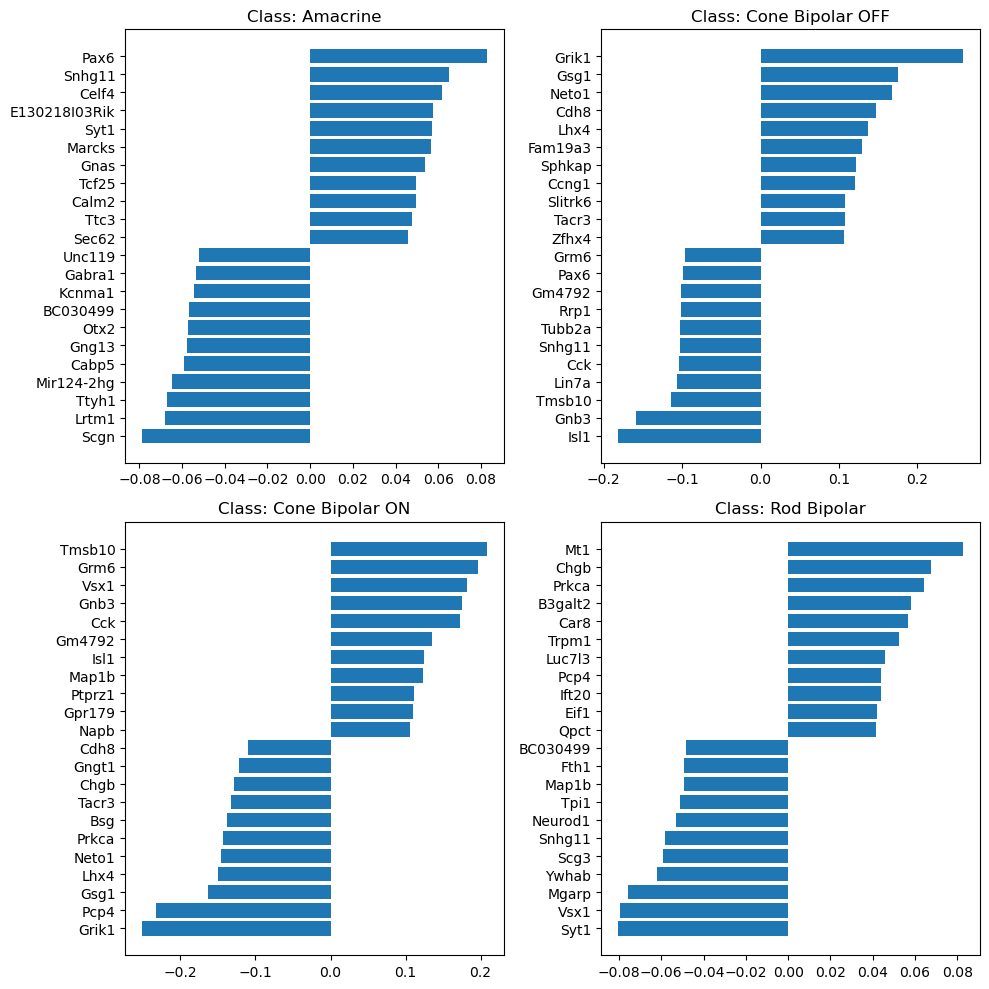

In [188]:
fig.tight_layout()
fig

In [56]:
zipped = zip(clfit.coef_, clfit.feature_names_in_)

In [50]:
srt = sorted(zipped, key = lambda x: x[0])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [60]:
np.dstack((clfit.coef_, clfit.feature_names_in_))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 6 and the array at index 1 has size 1

In [62]:
clfit.coef_

array([[ 0.01086267,  0.01942573, -0.01764738, ..., -0.01253612,
         0.00090316, -0.00093089],
       [ 0.01548277,  0.02197637, -0.00727526, ..., -0.00735823,
         0.00429688, -0.00031591],
       [ 0.00364681,  0.00756902, -0.00494678, ..., -0.01509505,
         0.00728775,  0.00625369],
       [ 0.05026314, -0.03245349,  0.00776888, ...,  0.0502917 ,
        -0.06066927, -0.00244713],
       [ 0.01470169,  0.00800045,  0.00203586, ..., -0.00775471,
        -0.00823924,  0.00442413],
       [ 0.00783532,  0.01197218,  0.00103081, ..., -0.00485162,
        -0.00225956,  0.00660936]])

In [70]:
clfit.coef_

6